CNN Visual Classification (Aircraft Family)

Convolutional Neural Network (CNN) image classifier to recognise 5 aircraft types.

Plane Types: A320, A340, A380, B737, B777

Used transfer learning with a pretrained ResNet18 model, then progressively improve performance across three iterations by:
1. Training a new classifier head
2. Fine-tuning deeper layers with augmentation
3. Addressing plane type imbalance using weighted CrossEntropyLoss

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dataset used is the FGVC-Aircraft dataset which contains aircraft images labelled by aircraft types.

In [66]:
!cp /content/drive/MyDrive/fgvc-aircraft-2013b.tar.gz .
!cp /content/drive/MyDrive/fgvc-aircraft-2013b-annotations.tar.gz .
!ls

aircraft5  fgvc-aircraft-2013b			   fgvc-aircraft-2013b.tar.gz
drive	   fgvc-aircraft-2013b-annotations.tar.gz  sample_data


In [67]:
!tar -xvf fgvc-aircraft-2013b.tar.gz
!tar -xvf fgvc-aircraft-2013b-annotations.tar.gz

Streaming output truncated to the last 5000 lines.
fgvc-aircraft-2013b/data/images/1349345.jpg
fgvc-aircraft-2013b/data/images/0894316.jpg
fgvc-aircraft-2013b/data/images/1244306.jpg
fgvc-aircraft-2013b/data/images/1396258.jpg
fgvc-aircraft-2013b/data/images/1534214.jpg
fgvc-aircraft-2013b/data/images/0275792.jpg
fgvc-aircraft-2013b/data/images/0345781.jpg
fgvc-aircraft-2013b/data/images/1754078.jpg
fgvc-aircraft-2013b/data/images/1818166.jpg
fgvc-aircraft-2013b/data/images/0469140.jpg
fgvc-aircraft-2013b/data/images/1839235.jpg
fgvc-aircraft-2013b/data/images/2074712.jpg
fgvc-aircraft-2013b/data/images/0302207.jpg
fgvc-aircraft-2013b/data/images/0169635.jpg
fgvc-aircraft-2013b/data/images/1879116.jpg
fgvc-aircraft-2013b/data/images/1420123.jpg
fgvc-aircraft-2013b/data/images/1773176.jpg
fgvc-aircraft-2013b/data/images/1106369.jpg
fgvc-aircraft-2013b/data/images/0547020.jpg
fgvc-aircraft-2013b/data/images/0779581.jpg
fgvc-aircraft-2013b/data/images/0522830.jpg
fgvc-aircraft-2013b/data/

In [68]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Reproducibility (slower but consistent)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [69]:
import shutil
from pathlib import Path

# Paths
ROOT = Path("fgvc-aircraft-2013b") / "data"
IMG_DIR = ROOT / "images"
OUT_DIR = Path("aircraft5")

# The 5 plane models, quoted from families.txt
TARGET_FAMILIES = {
    "Boeing 737": "B737",
    "Boeing 777": "B777",
    "A320": "A320",
    "A340": "A340",
    "A380": "A380",
}

SPLITS = {
    "train": ROOT / "images_family_train.txt",
    "val":   ROOT / "images_family_val.txt",
    "test":  ROOT / "images_family_test.txt",
}

def parse_split(path: Path):
    rows = []
    for line in path.read_text(encoding="utf-8").splitlines():
        if not line.strip():
            continue
        parts = line.split()
        img_id = parts[0]
        family = " ".join(parts[1:])
        rows.append((img_id, family))
    return rows

# Fresh output folder
if OUT_DIR.exists():
    shutil.rmtree(OUT_DIR)

# Create folders
for split in SPLITS:
    for short in TARGET_FAMILIES.values():
        (OUT_DIR / split / short).mkdir(parents=True, exist_ok=True)

# Copy files
counts = {split: {short: 0 for short in TARGET_FAMILIES.values()} for split in SPLITS}
totals = {split: 0 for split in SPLITS}

for split, split_file in SPLITS.items():
    for img_id, family in parse_split(split_file):
        if family not in TARGET_FAMILIES:
            continue
        cls = TARGET_FAMILIES[family]
        src = IMG_DIR / f"{img_id}.jpg"
        dst = OUT_DIR / split / cls / f"{img_id}.jpg"
        if src.exists():
            shutil.copy2(src, dst)
            counts[split][cls] += 1
            totals[split] += 1

print("✅ Built dataset at:", OUT_DIR.resolve())
print("Totals:", totals)
for split in counts:
    print(f"\n[{split}]")
    for cls, n in counts[split].items():
        print(f"  {cls}: {n}")

✅ Built dataset at: /content/aircraft5
Totals: {'train': 633, 'val': 632, 'test': 635}

[train]
  B737: 267
  B777: 66
  A320: 133
  A340: 133
  A380: 34

[val]
  B737: 266
  B777: 67
  A320: 133
  A340: 133
  A380: 33

[test]
  B737: 267
  B777: 67
  A320: 134
  A340: 134
  A380: 33


In [70]:
!pip -q install torch torchvision torchaudio scikit-learn

import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix


In [71]:
DATA_DIR = "aircraft5"
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 2
EPOCHS = 10
LR = 1e-3

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [72]:
import matplotlib.pyplot as plt

def plot_history(hist, title):
    epochs = range(1, len(hist["train_loss"]) + 1)

    plt.figure()
    plt.plot(epochs, hist["train_loss"], label="train loss")
    plt.plot(epochs, hist["val_loss"], label="val loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(f"{title} - Loss")
    plt.legend(); plt.show()

    plt.figure()
    plt.plot(epochs, hist["train_acc"], label="train acc")
    plt.plot(epochs, hist["val_acc"], label="val acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title(f"{title} - Accuracy")
    plt.legend(); plt.show()

In [73]:
# Iteration 1
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

train_ds = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=train_tfms)
val_ds   = datasets.ImageFolder(os.path.join(DATA_DIR, "val"),   transform=eval_tfms)
test_ds  = datasets.ImageFolder(os.path.join(DATA_DIR, "test"),  transform=eval_tfms)

class_names = train_ds.classes
num_classes = len(class_names)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

class_names, num_classes

(['A320', 'A340', 'A380', 'B737', 'B777'], 5)

ResNet18 model is used as the backbone. I chose ResNet18 as it has a strong baseline for image classification. It is pretrained on ImageNet so it has already learnt general visual features like edges, textures, and shapes. It is also lightweight enough to train efficiently within assignment constraints.

In Iteration 1, the ResNet18 backbone is frozen and only the final classifier layer is trained.
This is because freezing most parameters reduces training time and prevents overfitting when the dataset is limited. However it may struggle to separate visually similar aircraft types like the A320 and B737.

In [74]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Freeze backbone
for p in model.parameters():
    p.requires_grad = False

# Replace classifier head
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=LR)

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [75]:
def accuracy_from_logits(logits, y):
    preds = torch.argmax(logits, dim=1)
    return (preds == y).float().mean().item()

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(1, EPOCHS + 1):
    # ---- train ----
    model.train()
    train_losses, train_accs = [], []

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        train_accs.append(accuracy_from_logits(logits, y))

    # ---- val ----
    model.eval()
    val_losses, val_accs = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)

            val_losses.append(loss.item())
            val_accs.append(accuracy_from_logits(logits, y))

    tl, ta = float(np.mean(train_losses)), float(np.mean(train_accs))
    vl, va = float(np.mean(val_losses)), float(np.mean(val_accs))

    history["train_loss"].append(tl)
    history["train_acc"].append(ta)
    history["val_loss"].append(vl)
    history["val_acc"].append(va)

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"train loss {tl:.4f} acc {ta:.4f} | "
          f"val loss {vl:.4f} acc {va:.4f}")

Epoch 01/10 | train loss 1.4590 acc 0.4015 | val loss 1.3605 acc 0.4234
Epoch 02/10 | train loss 1.2451 acc 0.5079 | val loss 1.2179 acc 0.5047
Epoch 03/10 | train loss 1.1128 acc 0.5865 | val loss 1.1581 acc 0.5083
Epoch 04/10 | train loss 1.0380 acc 0.6110 | val loss 1.0668 acc 0.5682
Epoch 05/10 | train loss 0.9470 acc 0.6563 | val loss 1.0258 acc 0.5870
Epoch 06/10 | train loss 0.8820 acc 0.7034 | val loss 0.9694 acc 0.6630
Epoch 07/10 | train loss 0.8535 acc 0.7217 | val loss 0.9644 acc 0.6656
Epoch 08/10 | train loss 0.8216 acc 0.7150 | val loss 0.9065 acc 0.6818
Epoch 09/10 | train loss 0.7597 acc 0.7449 | val loss 0.8908 acc 0.6849
Epoch 10/10 | train loss 0.7364 acc 0.7719 | val loss 0.8557 acc 0.7005


In [76]:
all_preds, all_true = [], []

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.append(preds)
        all_true.append(y.numpy())

all_preds = np.concatenate(all_preds)
all_true = np.concatenate(all_true)

print("Classification report:")
print(classification_report(all_true, all_preds, target_names=class_names, digits=4))

cm = confusion_matrix(all_true, all_preds)
cm

Classification report:
              precision    recall  f1-score   support

        A320     0.5583    0.5000    0.5276       134
        A340     0.7095    0.7836    0.7447       134
        A380     0.3077    0.1212    0.1739        33
        B737     0.7179    0.8577    0.7816       267
        B777     0.7429    0.3881    0.5098        67

    accuracy                         0.6787       635
   macro avg     0.6072    0.5301    0.5475       635
weighted avg     0.6637    0.6787    0.6599       635



array([[ 67,   3,   3,  60,   1],
       [ 12, 105,   4,  11,   2],
       [  5,  15,   4,   6,   3],
       [ 23,  12,   0, 229,   3],
       [ 13,  13,   2,  13,  26]])

From the report above, we can see that the model is learning, but performance is uneven across the plane types.

A380 is the biggest problem where:
Recall = 0.1212, meaning it only correctly catches around 12% of A380s.

A320 is heavily confused with B737, meaning the baseline features are not strong enough to separate similar narrow-body silhouettes.

B777 has a low recall of 0.3881, meaning many B777 images are being misread as other wide-body planes.

Overall iteration 1 is not bad on majority classes, but weak on minority classes.

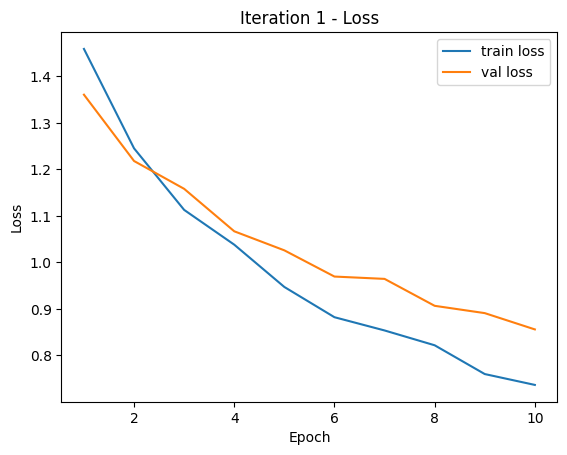

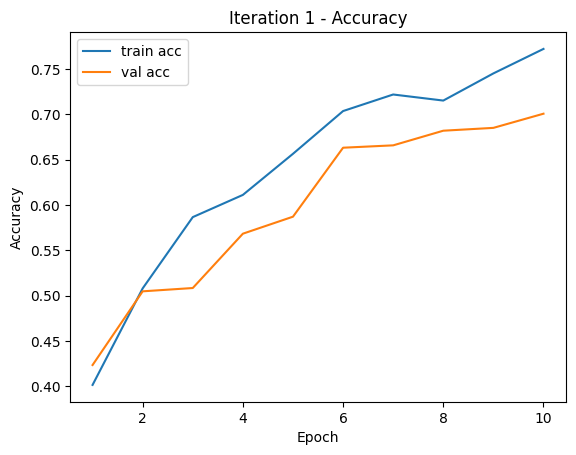

In [77]:
plot_history(history, "Iteration 1")

From iteration 1 line graph above,
- Training loss decreases steadily, indicating that the classifier head is learning basic patterns from the data
- However validation loss slows down early and remains higher than the training loss.
- Training accuracy increases gradually, but validation accuracy saturates at a relatively low level

This suggests limited generalisation. With the backbone frozen, the model cannot adapt deeper visual features to aircraft-specific characteristics. As a result, learning is constrained and biased toward majority classes.

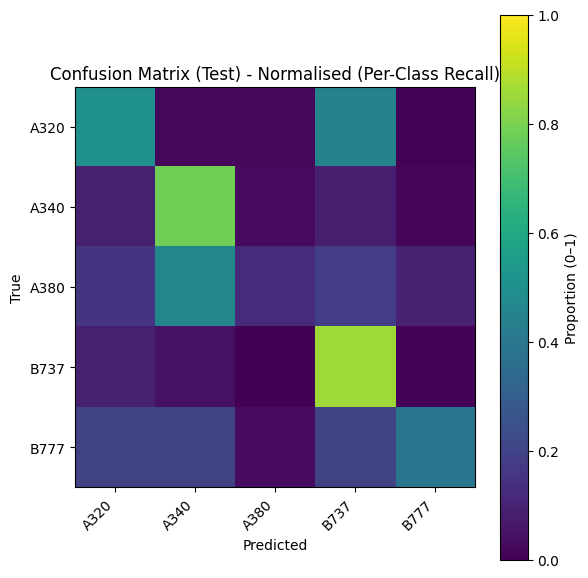

In [78]:
# Iteration 1 Confusion Matrix (Normalised colourway)
import matplotlib.pyplot as plt
import numpy as np

cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6, 6))
plt.imshow(cm_norm, vmin=0, vmax=1, cmap="viridis", interpolation="nearest")
plt.xticks(range(num_classes), class_names, rotation=45, ha="right")
plt.yticks(range(num_classes), class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test) - Normalised (Per-Class Recall)")
plt.colorbar(label="Proportion (0–1)")
plt.tight_layout()
plt.show()

From the confusion matrix above:
- It shows heavy bias toward majority classes, especially B737.
- A380 is frequently misclassified as A340
- Significant confusion exists between A320 and B737, likely due to similar narrow-body proportions and common airline liveries.
- B777 is often misclassified as other wide-body aircraft, indicating difficulty distinguishing size and engine placement from certain viewpoints.

Overall, the baseline model lacks sufficient discriminative power and is strongly affected by class imbalance, resulting in poor minority-class recall.

In [79]:
# Iteration 2
from torchvision import transforms

train_tfms_v2 = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

eval_tfms_v2 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

In [80]:
import os
from torchvision import datasets
from torch.utils.data import DataLoader

DATA_DIR = "aircraft5"
BATCH_SIZE = 32
NUM_WORKERS = 2

train_ds = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=train_tfms_v2)
val_ds   = datasets.ImageFolder(os.path.join(DATA_DIR, "val"),   transform=eval_tfms_v2)
test_ds  = datasets.ImageFolder(os.path.join(DATA_DIR, "test"),  transform=eval_tfms_v2)

class_names = train_ds.classes
num_classes = len(class_names)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

class_names

['A320', 'A340', 'A380', 'B737', 'B777']

For iteration 2, the model is improved by unfreezing and fine-tuning the final ResNet block and the classifier head. A stronger data augmentation is also appplied. Used a learning rate scheduler to stabilise training.
Fine-tuning allows high-level features to adapt to aircraft-specific patterns such as the fuselage, tail shape, engine placement etc. Stronger augmentation improves generalisation and reduces memorisation of the training set.

In [81]:
import torch
import torch.nn as nn
from torchvision import models

device = "cuda" if torch.cuda.is_available() else "cpu"

model2 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Freeze everything first
for p in model2.parameters():
    p.requires_grad = False

# Unfreeze LAST residual block (layer4) for fine-tuning
for p in model2.layer4.parameters():
    p.requires_grad = True

# Replace classifier head
in_features = model2.fc.in_features
model2.fc = nn.Linear(in_features, num_classes)

model2 = model2.to(device)

criterion = nn.CrossEntropyLoss()

# Different LRs: smaller for layer4, bigger for new head
optimizer = torch.optim.Adam([
    {"params": model2.layer4.parameters(), "lr": 1e-4},
    {"params": model2.fc.parameters(),     "lr": 1e-3},
])

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

model2

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [82]:
import copy
import numpy as np

def accuracy_from_logits(logits, y):
    preds = torch.argmax(logits, dim=1)
    return (preds == y).float().mean().item()

history2 = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

EPOCHS = 8
best_val_acc = -1
best_state = None

for epoch in range(1, EPOCHS + 1):
    # ---- train ----
    model2.train()
    train_losses, train_accs = [], []

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model2(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        train_accs.append(accuracy_from_logits(logits, y))

    # ---- val ----
    model2.eval()
    val_losses, val_accs = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model2(x)
            loss = criterion(logits, y)
            val_losses.append(loss.item())
            val_accs.append(accuracy_from_logits(logits, y))

    tl, ta = float(np.mean(train_losses)), float(np.mean(train_accs))
    vl, va = float(np.mean(val_losses)), float(np.mean(val_accs))

    history2["train_loss"].append(tl)
    history2["train_acc"].append(ta)
    history2["val_loss"].append(vl)
    history2["val_acc"].append(va)

    # step LR scheduler
    scheduler.step()

    # save best checkpoint
    if va > best_val_acc:
        best_val_acc = va
        best_state = copy.deepcopy(model2.state_dict())

    print(f"Epoch {epoch:02d}/{EPOCHS} | train acc {ta:.4f} | val acc {va:.4f} | best {best_val_acc:.4f}")

# load best model
model2.load_state_dict(best_state)
print("✅ Loaded best validation weights for Iteration 2.")
iter2_best_state = copy.deepcopy(model2.state_dict())

Epoch 01/8 | train acc 0.4853 | val acc 0.5437 | best 0.5437
Epoch 02/8 | train acc 0.6887 | val acc 0.6854 | best 0.6854
Epoch 03/8 | train acc 0.8137 | val acc 0.7464 | best 0.7464
Epoch 04/8 | train acc 0.8744 | val acc 0.7536 | best 0.7536
Epoch 05/8 | train acc 0.9018 | val acc 0.7797 | best 0.7797
Epoch 06/8 | train acc 0.9226 | val acc 0.8005 | best 0.8005
Epoch 07/8 | train acc 0.9542 | val acc 0.8068 | best 0.8068
Epoch 08/8 | train acc 0.9502 | val acc 0.8115 | best 0.8115
✅ Loaded best validation weights for Iteration 2.


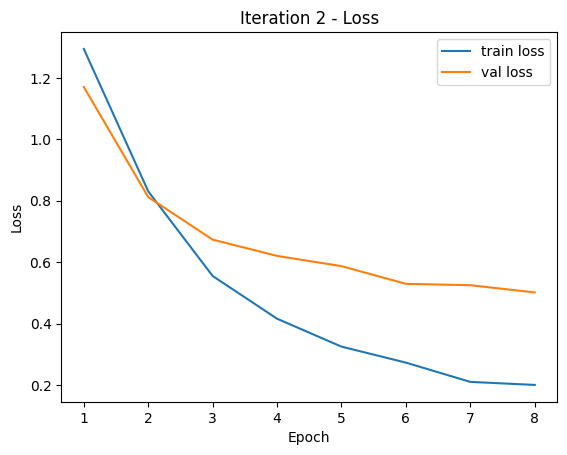

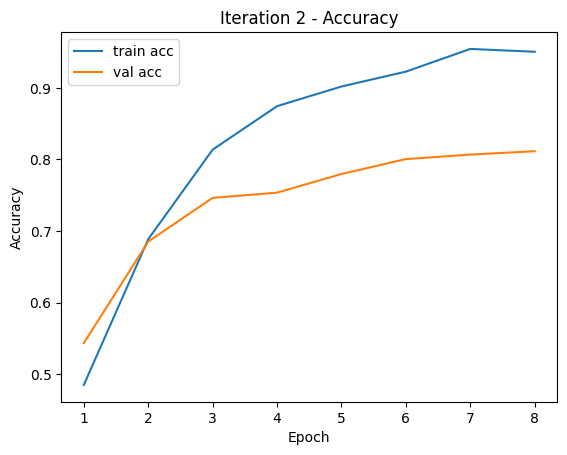

In [83]:

plot_history(history2, "Iteration 2")

For iteration 2 line graph above:
- Training loss decreases more rapidly than in iteration 1
- Validation loss also decreases, but more slowly, resulting in a larger gap between the two curves.
- Training accuracy rises faster than validation accuracy.

This pattern indicates stronger learning capacity and increased model flexibility due to fine-tuning:
- By unfreezing deeper layers, the model can now fit the training data much better.
- The increased gap suggests mild overfitting, which is expected when moving from a frozen backbone to fine-tuning.

In [84]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

all_preds, all_true = [], []

model2.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model2(x)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.append(preds)
        all_true.append(y.numpy())

all_preds = np.concatenate(all_preds)
all_true = np.concatenate(all_true)

print(classification_report(all_true, all_preds, target_names=class_names, digits=4))
cm2 = confusion_matrix(all_true, all_preds)
cm2

              precision    recall  f1-score   support

        A320     0.7769    0.7015    0.7373       134
        A340     0.7697    0.8731    0.8182       134
        A380     0.6897    0.6061    0.6452        33
        B737     0.8345    0.9064    0.8689       267
        B777     0.7674    0.4925    0.6000        67

    accuracy                         0.7969       635
   macro avg     0.7676    0.7159    0.7339       635
weighted avg     0.7941    0.7969    0.7904       635



array([[ 94,   5,   1,  32,   2],
       [  7, 117,   2,   3,   5],
       [  1,   6,  20,   4,   2],
       [ 13,   9,   2, 242,   1],
       [  6,  15,   4,   9,  33]])

From iteration 2 report above, there are big improvements.
- Overall accuracy jumps from 67.9% to 79.7%
- A380 improvess massively where recall goes from 0.1212 to 0.6061. This shows that fine-tuning  + augmentation helped the model learn aircraft-specific cues instead of only generic ImageNet features.
- A320 improves from recall of 0.5 to 0.7015
- B737 improves from recall 0.7836 to 0.8731
- B737 is the best class with recall of 0.9026, probably because it has the most data and consistent visual features.
- B777 recall is still only 0.5075 which fits the "wide body" ambiguity problem.


In [85]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def unnormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return (img * std + mean).clamp(0,1)

def show_misclassified(dataset, y_true, y_pred, class_names, n=9):
    wrong = np.where(y_true != y_pred)[0]
    print("Misclassified:", len(wrong))
    n = min(n, len(wrong))

    plt.figure(figsize=(10,10))
    for i in range(n):
        idx = wrong[i]
        img, _ = dataset[idx]
        img = unnormalize(img)

        plt.subplot(3,3,i+1)
        plt.imshow(img.permute(1,2,0))
        plt.axis("off")
        plt.title(f"T: {class_names[y_true[idx]]}\nP: {class_names[y_pred[idx]]}")
    plt.tight_layout()
    plt.show()

Misclassified: 129


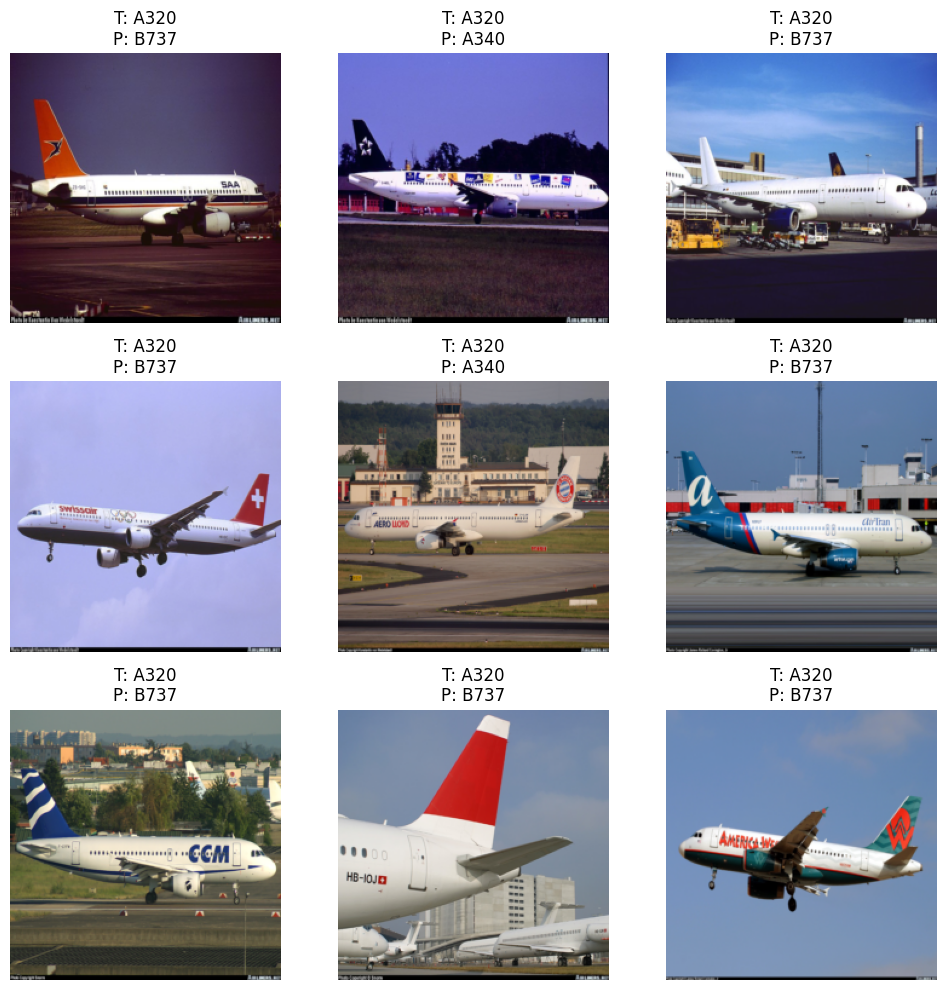

In [86]:
show_misclassified(test_ds, all_true, all_preds, class_names, n=9)

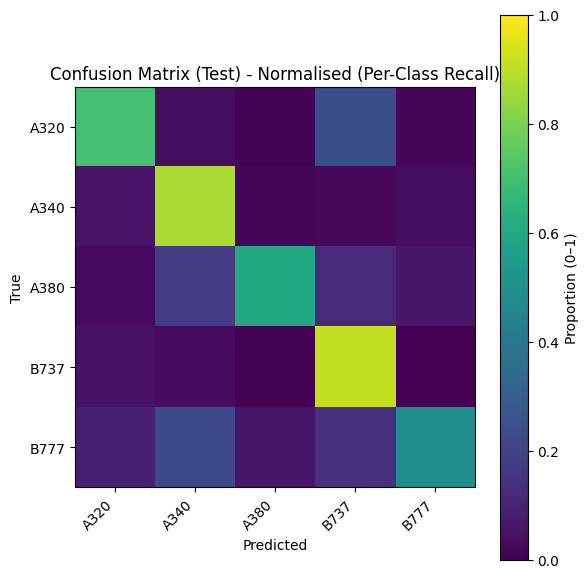

In [87]:
# Iteration 2 Confusion Matrix (Normalised colourway)
import matplotlib.pyplot as plt
import numpy as np

cm2_norm = cm2.astype(float) / cm2.sum(axis=1, keepdims=True)

plt.figure(figsize=(6, 6))
plt.imshow(cm2_norm, vmin=0, vmax=1,cmap="viridis", interpolation="nearest")
plt.xticks(range(num_classes), class_names, rotation=45, ha="right")
plt.yticks(range(num_classes), class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test) - Normalised (Per-Class Recall)")
plt.colorbar(label="Proportion (0–1)")
plt.tight_layout()
plt.show()

For the confusion matrix above:
- The diagonal of the confusion matrix becomes more obvious and pronounced, indicating improved correct classification.
- A380 recall improves substantially, with fewer misclassifications into other Airbus or Boeing families.
- A340 and B737 achieve high recall, showing strong class separation.
- B777 still exhibits confusion with other wide-body aircrafts, but less severe than in iteration 1.

Iteration 2 delivers the largest overall performance improvement. Fine-tuning and augmentation significantly enhance feature discrimination and reduce systematic misclassification.

In [88]:
import numpy as np
from collections import Counter

train_labels = [y for _, y in train_ds.samples]
counts = Counter(train_labels)

print("Class order:", class_names)
print("Train counts:")
for i, name in enumerate(class_names):
    print(f"{name}: {counts[i]}")

# The result below shows that there is a crazy imbalance, where A380 has only 34 samples whereas B737 has 267

Class order: ['A320', 'A340', 'A380', 'B737', 'B777']
Train counts:
A320: 133
A340: 133
A380: 34
B737: 267
B777: 66


In [89]:
from collections import Counter
import numpy as np
import torch
import torch.nn as nn

# get class labels from training dataset
train_labels = [y for _, y in train_ds.samples]

# count samples per class
counts = Counter(train_labels)

# build count array in correct class index order
count_arr = np.array(
    [counts[i] for i in range(len(class_names))],
    dtype=np.float32
)

# inverse frequency weighting
weights = count_arr.sum() / (len(count_arr) * count_arr)

# convert to tensor
weights = torch.tensor(weights, dtype=torch.float32).to(device)

# weighted loss
criterion3 = nn.CrossEntropyLoss(weight=weights)

The tensor order is A320, A340, A380, B737, B777. Made it such that the weights of A380 is very high and weights for B737 is very low to balance them out. It also tells the loss function that mistakes on the A380 matters more than the other plane models. So the model will be pushed to focus more on the A380 and not overfit the B737.

In [90]:
# Iteration 3: weighted loss + reset optimizer/scheduler
import copy
import numpy as np
import torch
import torch.nn as nn
from torchvision import models

EPOCHS = 10
best_val_acc = -1
best_state3 = None
history_weighted = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

# 1) Rebuild the same Iter2 model architecture
model3 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Freeze everything first
for p in model3.parameters():
    p.requires_grad = False

# Unfreeze LAST residual block (layer4)
for p in model3.layer4.parameters():
    p.requires_grad = True

# Replace classifier head
in_features = model3.fc.in_features
model3.fc = nn.Linear(in_features, num_classes)

model3 = model3.to(device)

# 2) Load Iteration 2 best weights (captured after Iter2)
model3.load_state_dict(iter2_best_state)

# 3) Weighted loss (you already computed weights in Cell 23)
criterion3 = nn.CrossEntropyLoss(weight=weights)

# 4) RESET optimizer + scheduler (no carry-over)
optimizer3 = torch.optim.Adam([
    {"params": model3.layer4.parameters(), "lr": 1e-4},
    {"params": model3.fc.parameters(),     "lr": 1e-3},
])
scheduler3 = torch.optim.lr_scheduler.StepLR(optimizer3, step_size=3, gamma=0.5)

# 5) Train + validate
for epoch in range(1, EPOCHS + 1):
    # ---- train ----
    model3.train()
    train_losses, train_accs = [], []

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer3.zero_grad()
        logits = model3(x)
        loss = criterion3(logits, y)
        loss.backward()
        optimizer3.step()

        train_losses.append(loss.item())
        train_accs.append((logits.argmax(1) == y).float().mean().item())

    # ---- val ----
    model3.eval()
    val_losses, val_accs = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model3(x)
            loss = criterion3(logits, y)

            val_losses.append(loss.item())
            val_accs.append((logits.argmax(1) == y).float().mean().item())

    scheduler3.step()

    tl, ta = float(np.mean(train_losses)), float(np.mean(train_accs))
    vl, va = float(np.mean(val_losses)), float(np.mean(val_accs))

    history_weighted["train_loss"].append(tl)
    history_weighted["train_acc"].append(ta)
    history_weighted["val_loss"].append(vl)
    history_weighted["val_acc"].append(va)

    if va > best_val_acc:
        best_val_acc = va
        best_state3 = copy.deepcopy(model3.state_dict())

    print(f"Epoch {epoch:02d}/{EPOCHS} | train acc {ta:.4f} | val acc {va:.4f} | best {best_val_acc:.4f}")

# load best model for Iteration 3
model3.load_state_dict(best_state3)
print("✅ Loaded best validation weights for Iteration 3 (weighted loss).")

Epoch 01/10 | train acc 0.9246 | val acc 0.7990 | best 0.7990
Epoch 02/10 | train acc 0.9453 | val acc 0.8172 | best 0.8172
Epoch 03/10 | train acc 0.9672 | val acc 0.7990 | best 0.8172
Epoch 04/10 | train acc 0.9777 | val acc 0.8193 | best 0.8193
Epoch 05/10 | train acc 0.9699 | val acc 0.8307 | best 0.8307
Epoch 06/10 | train acc 0.9839 | val acc 0.8313 | best 0.8313
Epoch 07/10 | train acc 0.9792 | val acc 0.8276 | best 0.8313
Epoch 08/10 | train acc 0.9902 | val acc 0.8375 | best 0.8375
Epoch 09/10 | train acc 0.9859 | val acc 0.8333 | best 0.8375
Epoch 10/10 | train acc 0.9922 | val acc 0.8333 | best 0.8375
✅ Loaded best validation weights for Iteration 3 (weighted loss).


In [91]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

all_preds, all_true = [], []

model3.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model3(x)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_true.append(y.numpy())

all_preds = np.concatenate(all_preds)
all_true = np.concatenate(all_true)

print(classification_report(all_true, all_preds, target_names=class_names, digits=4))
cm_weighted = confusion_matrix(all_true, all_preds)
cm_weighted

              precision    recall  f1-score   support

        A320     0.7619    0.7164    0.7385       134
        A340     0.8559    0.7537    0.8016       134
        A380     0.8276    0.7273    0.7742        33
        B737     0.8227    0.9213    0.8693       267
        B777     0.6984    0.6567    0.6769        67

    accuracy                         0.8047       635
   macro avg     0.7933    0.7551    0.7721       635
weighted avg     0.8040    0.8047    0.8021       635



array([[ 96,   2,   1,  35,   0],
       [ 13, 101,   2,   6,  12],
       [  0,   2,  24,   3,   4],
       [ 11,   6,   1, 246,   3],
       [  6,   7,   1,   9,  44]])

From iteration 3, applying Weighted CrossEntropyLoss successfully mitigates class imbalance by prioritising minority classes during training.
- A380 recall improves further from 0.6061 to 0.7273, f1-score increases from 0.6452 to 0.7742.
- B777 recall improves substantially from 0.4925 to 0.6567
- Macro F1 improves notably, indicating more balanced performance across all classes.

While the overall accuracy gain is modest, the improvement in minority-class recall and macro F1 demonstrates a fairer and more robust classifier.

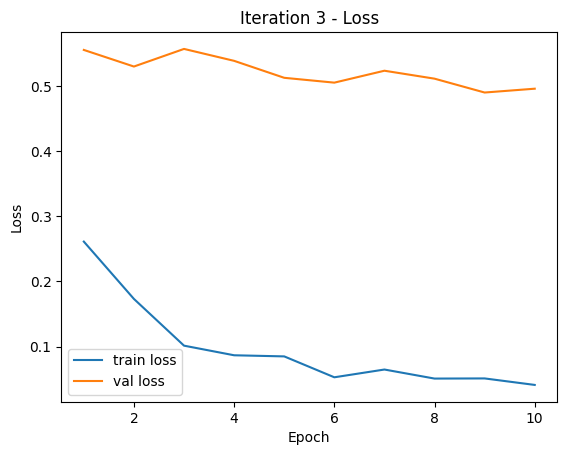

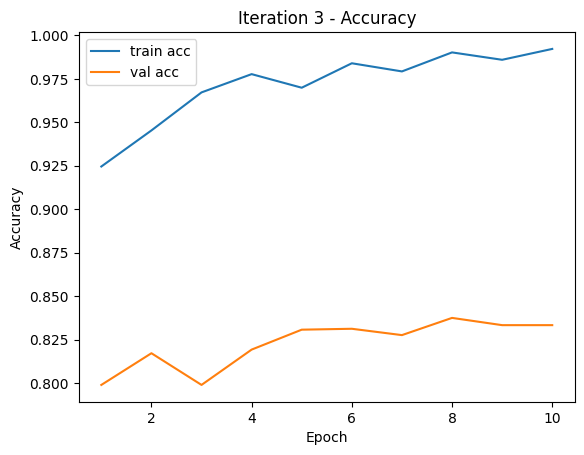

In [92]:
plot_history(history_weighted, "Iteration 3")

For iteration 3 line graph above:
- Training loss continues to decrease and training accuracy increases to very high levels, indicating strong fitting to the training data.
- Validation accuracy improves overall but fluctuates across epochs, reaching a peak before slightly decreasing in the next 2 epochs.

This suggests that the weighted-loss model reaches optimal generalisation mid-training, after which mild overfitting begins. Therefore loading the best validation checkpoint is therefore necessary, and weighted loss successfully improves class-balanced learning without destabilising training.

Misclassified: 124


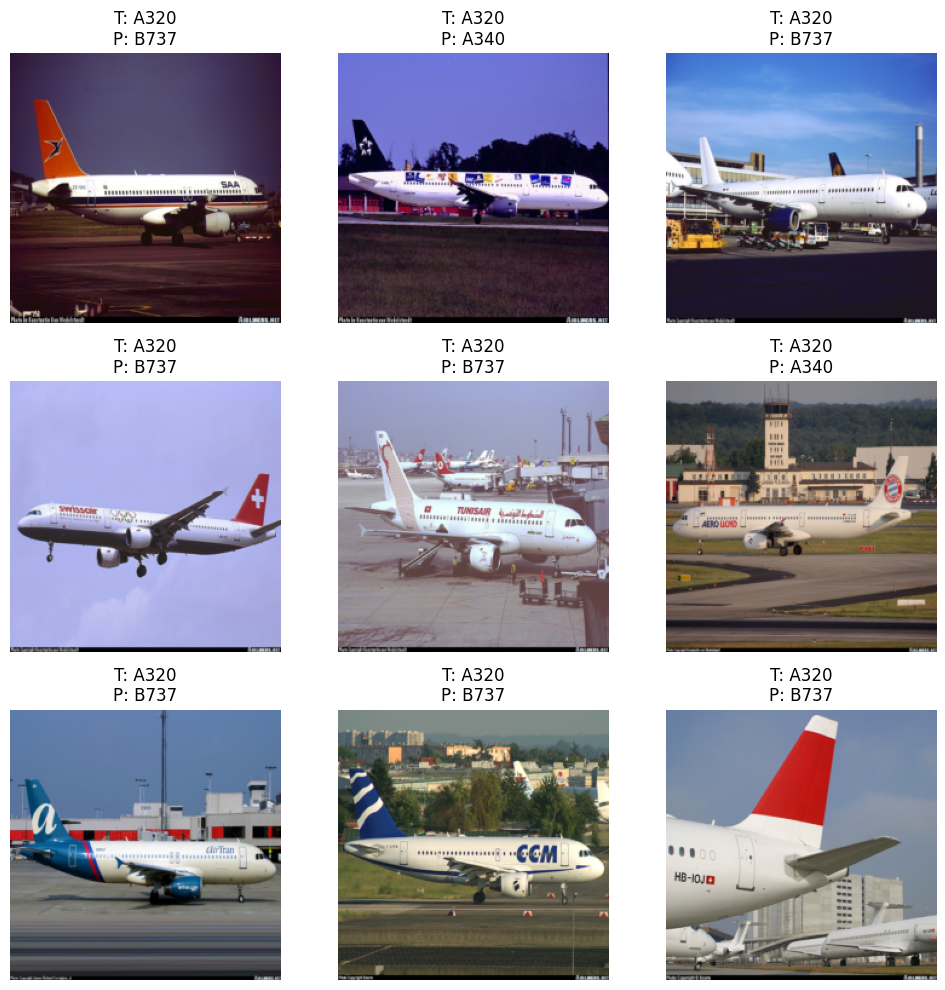

In [93]:
show_misclassified(test_ds, all_true, all_preds, class_names, n=9)

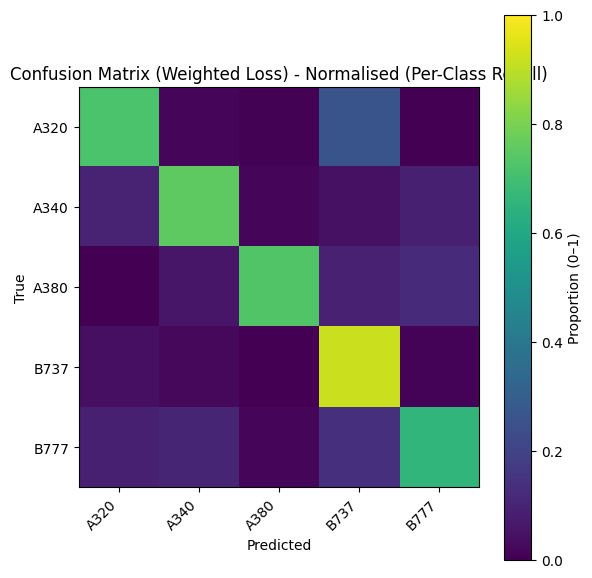

In [94]:
# Iteration 3 Confusion Matrix (Normalised colourway)
import matplotlib.pyplot as plt
import numpy as np

cmw_norm = cm_weighted.astype(float) / cm_weighted.sum(axis=1, keepdims=True)

plt.figure(figsize=(6, 6))
plt.imshow(cmw_norm, vmin=0, vmax=1,cmap="viridis", interpolation="nearest")
plt.colorbar(label="Proportion (0–1)")
ticks = np.arange(len(class_names))
plt.xticks(ticks, class_names, rotation=45, ha="right")
plt.yticks(ticks, class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Weighted Loss) - Normalised (Per-Class Recall)")
plt.tight_layout()
plt.show()

For the confusion matrix above,
- The confusion matrix becomes more balanced across classes.
- A380 classifications increased more, showing that weighted loss successfully improves minority-class recognition.
- B777 predictions improve, with more samples correctly classified and fewer being absorbed into majority classes.
- While B737 remains the strongest class, it no longer dominates predictions as heavily as in iteration 1.

This suggests that applying weighted loss effectively mitigates class imbalance, resulting in more balanced and fair performance within the plane types while maintaining strong recognition of majority classes.